In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all the names in the dataset
words = open('names.txt',  'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
#building the vocabulary of characters and mapping them to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [53]:
#build datasets

block_size = 3 # context length
vocab_size = 27 # number of chars in our char vocabulary (total possible outputs)

def build_dataset(words):
    #dataset prep
    X, Y = [], []  
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       #80%
Xdev, Ydev = build_dataset(words[n1:n2])   #10%
Xte, Yte = build_dataset(words[n2:])       #10%

In [59]:
g = torch.Generator().manual_seed(2147483647) #for reproducibility

n_embed = 10 # dimensions of the embedding vectors corresponding to each of the character
n_hidden = 200 # number of neurons in the hidden tanh layer

#initialisation
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * 0.2 #very very low to avoid hpreact taking extreme values leading to tanh being 1/ -1 and the on backprop becasue of 1- t**2 differential, no gradient descent will change the value of the neuron and these are effectively dead neurons
b1 = torch.randn(n_hidden,                         generator=g) * 0.01 # same as above reason
W2 = torch.rand((n_hidden, vocab_size),            generator=g) * 0.01 # same reason as below, trying to make logits all as small (close to zero) as possbile to have a good starting point
b2 = torch.rand(vocab_size,                        generator=g) * 0 # zero at initialisation because we want logits to be as small/ close to zera as possible (otherwise iteration 1 is way off that a smooth distribution loss)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [60]:
max_steps = 200000
batch_size = 64
lossi = []

for i in range(max_steps):
    
    #minibatch - samples that we want to train in this pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #batch_size, block_size (3) , embedding dimensions (10)
    embcat = emb.view(-1, block_size * n_embed) #concatenate the vectors
    hpreact = embcat @ W1 + b1  #hidden layer pre activation
    h = torch.tanh(hpreact) #hidden layer 
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backard pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 10**-0.75 if i < max_steps/2 else 10**-1.75 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.2965


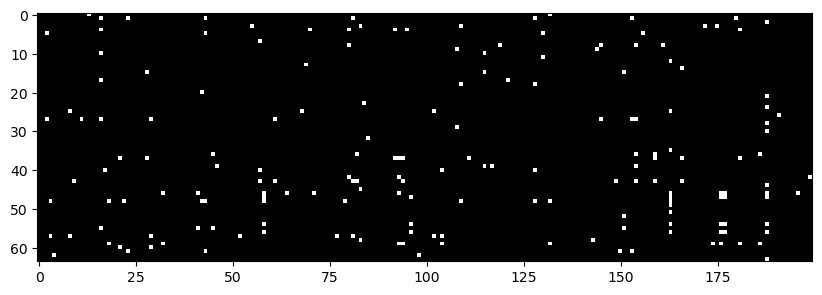

In [63]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

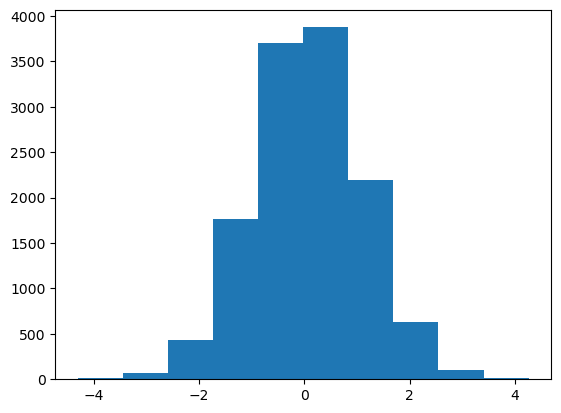

In [62]:
plt.hist(hpreact.view(-1).tolist());

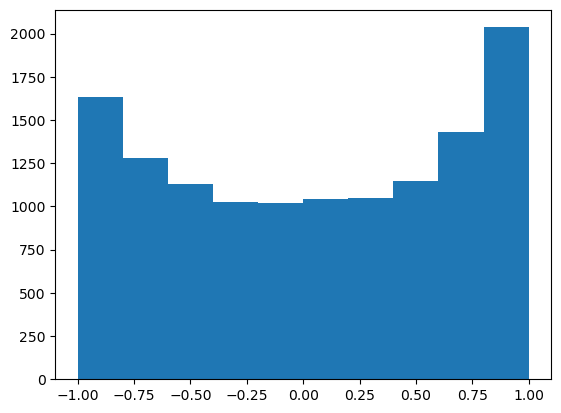

In [61]:
plt.hist(h.view(-1).tolist());

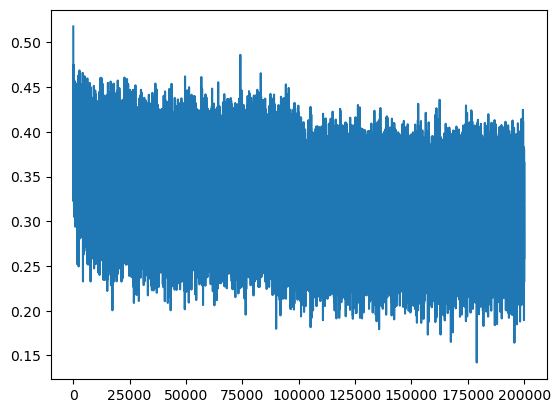

In [33]:
plt.plot(lossi)

In [36]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) #concat into N(total samples), block_size * n_embed
    h = torch.tanh(embcat @ W1 + b1) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.043792963027954
dev 2.137561798095703


In [35]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initializing with . . .
    while True:
        #forward pass
        emb = C[torch.tensor([context])] #(1, block_size, n_embed)
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        #sample from the distribtion
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        #shifting the context window
        context = context[1:] + [ix]
        out.append(ix)
        #if we encounted a special character
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) #decode and print the generated word

carmah.
amille.
khy.
mili.
tatya.
kanys.
emmahnen.
deliah.
jareen.
nellara.
chaiivia.
leigh.
ham.
joce.
quinthorlin.
alianni.
wavero.
dearyxi.
jace.
pirra.
